# Principal Component Analysis (PCA) 

~~~
Extracción de Características en Imágenes.
Master en Ciencia de Datos e Ingeniería de Computadores.
Universidad de Granada.

Francisco Javier Sáez Maldonado - fjaviersaezm@ugr.es
Rafael Molina Soriano - rms@decsai.ugr.es

Créditos: Francisco Miguel Castro Macías, Fernando Pérez Bueno
~~~

Vamos a utilizar el análisis de componentes principales (Principal Component Analysis, PCA) sobre una base de datos de caras para reducir la dimensionalidad de cada cara extrayendo un conjunto de variables latentes. Estas variables latentes podrían, con posterioridad, utilizarse, por ejemplo, en problemas de clasificación siempre que los errores de reconstrucción de las caras usando las variables latentes fuese pequeño. También podrían usarse en problemas de detección de anomalías.

El fichero ERRDfaces.mat contiene una base de datos de caras almacenada por filas en la matriz `X`. Cada fila corresponde a una cara de 32x32=1024 píxeles en niveles de gris. El número de ejemplos es 5000.

Comenzamos importando las librerías que vamos a utilizar en el desarrollo de la práctica.

In [39]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

Especificamos la ruta donde están nuestros datos y los leemos. Observa la estructura que los contiene. Lee la documentación sobre la función `loadmat`.

In [40]:
import os 
path='.'
# Using os.path.join for better platform compatibility
dict_data = loadmat(os.path.join(path, 'ERRDfaces_2021.mat'))
print(dict_data)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Feb  2 12:53:02 2021', '__version__': '1.0', '__globals__': [], 'X': array([[ -37.86631387,  -45.86631387,  -53.86631387, ..., -110.86631387,
        -111.86631387,  -99.86631387],
       [   8.13368613,   -0.86631387,   -8.86631387, ...,  -34.86631387,
          -8.86631387,    0.13368613],
       [ -32.86631387,  -34.86631387,  -36.86631387, ..., -110.86631387,
        -111.86631387, -111.86631387],
       ...,
       [ -46.86631387,  -24.86631387,   -8.86631387, ...,   90.13368613,
          80.13368613,   59.13368613],
       [  19.13368613,   16.13368613,   14.13368613, ...,  -38.86631387,
         -41.86631387,  -46.86631387],
       [-108.86631387, -106.86631387, -102.86631387, ...,   17.13368613,
          17.13368613,   18.13368613]], shape=(5000, 1024))}


Como ves, los datos están almacenados en un diccionario. Extraemos nuestros datos usando la llave `X` y mostramos su dimensión.

In [41]:
data= dict_data['X']
data.shape

(5000, 1024)

Usaremos las 4.500 primeras caras como ejemplos de entrenamiento y las restantes 500 como test. El conjunto de test nos servirá para probar que PCA representa suficientemente bien la información como para aplicarlo a datos que no ha visto.

Dependiendo del problema podríamos usar todas las muestras como conjunto de entrenamiento. Por ejemplo, si quisiéramos detectar anomalías en el conjunto de imagenes, debemos usar un conjunto "de calibración".

> 📝 **Pregunta 1.** Completa el código para que la variable `X` siguiente contenga las 4500 primeras caras de `data` y `test` el resto.

In [42]:
from sklearn.model_selection import train_test_split
N_tr = 4500
X =  dict_data['X'][:4500]
test = dict_data['X'][4500:]
print(X.shape, test.shape)

(4500, 1024) (500, 1024)


Las caras están almacenadas como un vector de rasgos, donde cada imagen es una única fila. 

> 📝 **Pregunta 2.** Redimensiona, es decir, pasa de un vector con 1024 componentes a una matriz 32x32, y muestra las 5 primeras caras del dataset. Pueden resultarte utiles las funciones `np.reshape` y `plt.imshow`. Tal vez necesites trasponer la matriz que contiene la cara.

<Figure size 1500x800 with 0 Axes>

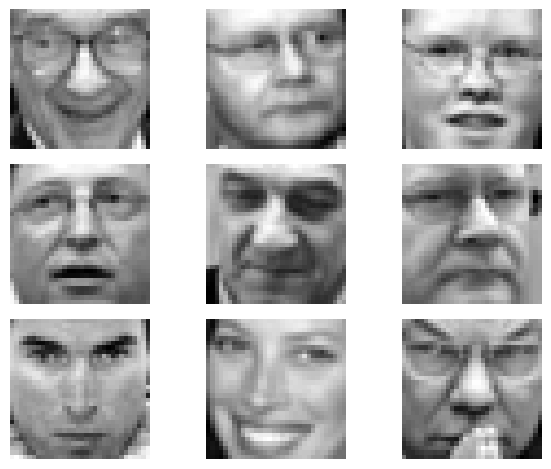

In [72]:
n_caras = 5
plt.figure(figsize=(15,8))
#Introduce aquí tu código
X = np.reshape(X, (X.shape[0], 32, 32)).transpose(0, 2, 1)
test = np.reshape(test, (test.shape[0], 32, 32)).transpose(0, 2, 1)
def plot_grid_images(data, rows: int = 3, cols: int = 3, **kws):
  fig, ax = plt.subplots(rows, cols, tight_layout=True)
  fig.update(props=kws)
  for i in range(rows):
    for j in range(cols):
      ax[i,j].imshow(data[i*cols + j], cmap='gray')
      ax[i,j].axis('off')
  
  return fig, ax

fix, ax = plot_grid_images(X)
plt.show()

# Normalización de los datos 

Para trabajar con modelos como PCA, es necesario normalizar los datos. Recuerda una de las primeras cosas que comentó Rafa:
\begin{equation*}
\mathbf{x} \approx \mathbf{\phi} \mathbf{z} \color{red}{+ \boldsymbol{\mu}}
\end{equation*}
"Nosotros supondremos que $\color{red}{\boldsymbol{\mu}=\boldsymbol{0}}$"

> 📝 **Pregunta 3.** Usando la clase `StandardScaler` de sklearn normaliza los datos de entrenamiento, de forma que cada rasgo (de los 1024) tenga media cero. No realices el escalado de la varianza a uno. Los rasgos normalizados deberás almacenarlos en la variable `X_norm`. Ten en cuenta que más tarde tendrás que aplicar la misma normalización a los datos de test.

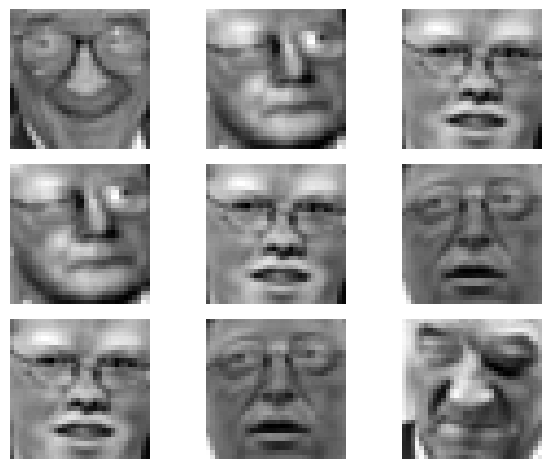

In [44]:
from sklearn.preprocessing import StandardScaler

# Introduce aquí tu código para normalizar los datos. Introduce los datos normalizados en una variable de nombre X_norm
scaler = StandardScaler(with_std=False)
X_norm = scaler.fit_transform(X.reshape(X.shape[0], 1024))
X_norm = X_norm.reshape(X.shape[0], 32, 32)
fig, ax = plot_grid_images(X_norm)
plt.show()

> 📝 **Pregunta 4.** Escribe código, lo más eficiente posible, para comprobar que las columnas de rasgos tienen media cero.

In [45]:
# Introduce aquí tu código
print(f"Media original: {np.mean(X)}", f"\nNueva media: {np.mean(X_norm)}")

Media original: -0.1082507161458337 
Nueva media: 4.410101913284355e-15


# Cálculo de las PCAs 

Una vez que has normalizado los datos. Utilizaremos `X_norm` para calcular las componentes principales. Aunque existe una función implementada en el paquete sklearn nosotros no la utilizaremos para comprender en profundidad el funcionamiento de PCAs. No se considera válido para el desarrollo de la práctica el uso de implementaciones de PCA en sklearn o cualquier otra libreria.

Supongamos que $\mathbf{X} \in \mathbb{R}^{N \times D}$ y que queremos proyectar nuestros datos en un espacio de dimensión $M$. Recuerda que el cálculo de las componentes principales viene dado por la solución al problema
$$ \min_{\mathbf{W} \in \mathbb{R}^{D \times M}, \mathbf{Z} \in \mathbb{R}^{N \times M}} \| \mathbf{X}^\top - \mathbf{W}\mathbf{Z}^\top\|_F^2.$$
En teoría hemos visto que tal solución viene dada tomando
$$ \mathbf{W} = \mathrm{Eigenvec}(\mathbf{S})_M, \quad \mathbf{Z}^\top = \mathbf{W}^\top \mathbf{X}^\top$$
donde $\mathrm{Eigenvec}(\mathbf{S})_M$ contiene los $M$ autovectores (vectores propios) con mayores autovalores (valores propios) de la matriz de covarianza muestral $\mathbf{S} = (1/N) \mathbf{X}^\top \mathbf{X}$. La reconstrucción se realiza tomando 
$$ \hat{\mathbf{X}}^\top =  \mathbf{W} \mathbf{Z}^\top.$$

Para calcular las componentes principales necesitamos calcular los autovectores de $\mathbf{X}^\top \mathbf{X}$. En teoría hemos visto que se pueden calcular a partir de la descomposición en valores singurales $\mathbf{X}^\top = \mathbf{V} \mathbf{D} \mathbf{U}^\top$. Tenemos que 
$$ \mathbf{S} = \frac{1}{N} \mathbf{V} \mathbf{D}^2 \mathbf{V}^\top,$$
lo que significa que los autovectores de $\mathbf{S}$ se encuentran en las columnas de $\mathbf{V}$ y los autovalores vienen dados por $\lambda_i = (1/N) \mathbf{D}_{ii}^2$. Recuerda que $\mathbf{D}$ es una matriz diagonal.

> 📝 **Pregunta 5.** Utiliza la descomposición por valores sigulares sobre `X_norm` o `X_norm` traspuesta usando la función `np.linalg.svd()`. Obtén los autovectores y con los valores singulares calcula los autovalores. Alternativamente, puedes calcular los autovectores y autovalores de la matriz de covarianza muestral de `X_norm` utilizando la función `np.linalg.eig()`. Tal vez sería bueno que lo hicieras con los dos métodos y comprobases que obtienes los mismos autovalores.

In [46]:
# Comprobamos la reconstrucción básica siguiendo la fórmula.
X_norm = X_norm.reshape(X.shape[0], X.shape[1] * X.shape[2])
N = X_norm.shape[0] - 1
S = (1/N) * (X_norm.transpose() @ X_norm)
print(S.shape)
# Obtain the values and the vectors
v, W = np.linalg.eig(S)
# Attempt to approximate X after calculating Z using all the vectors
Z = (W.transpose() @ X_norm.transpose()).transpose()
Xhat = (W @ Z.transpose()).transpose()
# The reconstruction using all the vectors should be close to the original data.
print(np.allclose(X_norm, Xhat))
# Rename previous variables for sanity
eigvalues, eigvectors = v, W
# Sort the indexes in descending order
eigval_indexes = np.argsort(eigvalues)[::-1]
eigvalues = eigvalues[eigval_indexes]
eigvectors = eigvectors[:, eigval_indexes]

(1024, 1024)
True


In [47]:
# Check if our covariance matrix matches the one from numpy
Snp = np.cov(X_norm, ddof=1, rowvar=False)
print(Snp.shape)
# Set an adecuate tolerance due to floating point errors. 
print(np.allclose(S, Snp, rtol=1e-3))

(1024, 1024)
True


In [48]:
# Attempt to do the same using the svd
U, D, Vt = np.linalg.svd(X_norm.transpose(), full_matrices=False)
V = Vt.transpose()
print(U.shape, D.shape, Vt.shape)
Dd = np.diag(D)
Sv = (1/N) * (U @ (Dd**2) @ U.transpose())
print(Sv.shape)
# Verificamos que nuesta matriz de covarianza sea parecida
print(np.allclose(Sv, Snp, rtol=1e-3))
sveig_values = (D**2) / N
sveig_vectors = U
svindexes = np.argsort(sveig_values)[::-1]
sveig_values = sveig_values[svindexes]
sveig_vectors = sveig_vectors[:, svindexes]

(1024, 1024) (1024,) (1024, 4500)
(1024, 1024)
True


In [49]:
# Verificamos los autovectores
Wc = sveig_vectors
Wt = eigvectors
# observamos si la norma es 1
print(np.linalg.norm(Wc, axis=1))
print(np.linalg.norm(Wt, axis=1))
# Observamos si coinciden?
print(Wc[:, 0])
print(Wt[:, 0])

[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[-0.02053028 -0.02281611 -0.02503985 ... -0.01779897 -0.01470725
 -0.01178217]
[0.02053028 0.02281611 0.02503985 ... 0.01779897 0.01470725 0.01178217]


In [50]:
# Verificamos si los autovalores coincide
print(eigvalues)
print(sveig_values)

[5.02005429e+05 2.32734642e+05 1.11046483e+05 ... 3.33048632e-01
 3.10555967e-01 2.96969021e-01]
[5.02005429e+05 2.32734642e+05 1.11046483e+05 ... 3.33048632e-01
 3.10555967e-01 2.96969021e-01]


In [51]:
res = S @ Wc
res2 = S @ Wt
# La norma por columna debería coincidir.
print(np.linalg.norm(res, axis=1))
print(np.linalg.norm(res2, axis=1))

[16676.38081185 17531.52138884 17910.34062031 ... 17000.45557466
 16119.97106375 15038.14418657]
[16676.38081185 17531.52138884 17910.34062031 ... 17000.45557466
 16119.97106375 15038.14418657]


In [52]:
# Introduce en autovalores los autovalores (ordenados) de la matriz de covarianza muestral
autovalores = eigvalues

# Introduce en autovectores los vectores (ordenados) que definen la transformación de PCA
autovectores = eigvectors.T

print(autovalores.shape, autovectores.shape)

(1024,) (1024, 1024)


# Número de componentes a utilizar

Vamos ahora a determinar cuantas componentes vamos a utilizar en nuestro analisis. Cada componente adicional explica parte de la varianza de nuestros datos. Queremos encontrar cuántas componentes son necesarias para representar bien nuestros datos. 

Usando los autovalores que hemos obtenido, podemos observar qué cantidad de información aporta cada una de las componentes. Las dos gráficas a continuación muestran esta información de dos formas diferentes.

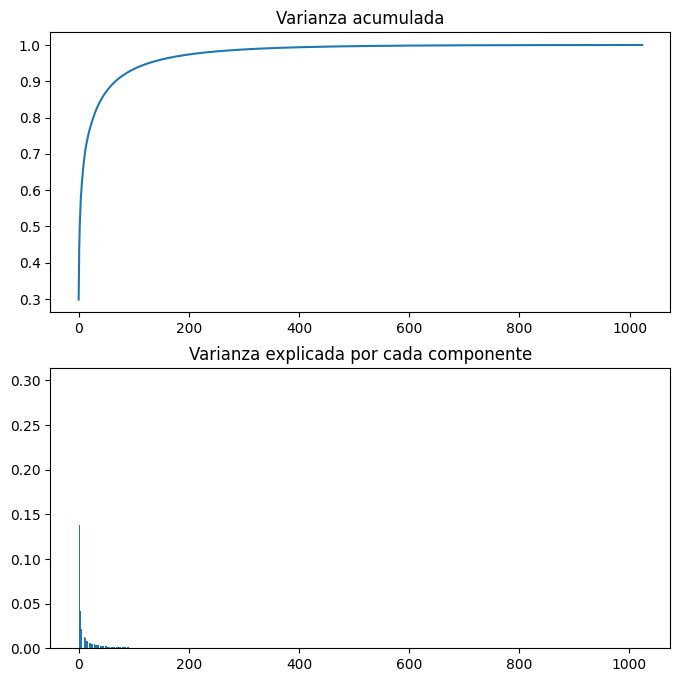

In [53]:
import matplotlib.pyplot as plt

#Hacemos uso de la suma acumulada de los autovalores para ver la varianza acumulada
cumsum=np.cumsum(autovalores)
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
cumvar = cumsum/cumsum[-1]
plt.plot(cumsum/cumsum[-1])
plt.title('Varianza acumulada')
plt.subplot(2,1,2)
#El aporte de cada autovalor a la suma total, nos muestra la varianza explicada por cada componente
plt.bar(range(autovalores.shape[0]),autovalores/np.sum(autovalores))
plt.title('Varianza explicada por cada componente')
plt.show()

Aunque podemos fijar el número de componentes manualmente tras estudiar los datos, es bueno que pienses como determinarías automáticamente el número de componentes a utilizar.

> 📝 **Pregunta 6.** ¿Qué harías para determinar cuál sería un buen número de componentes? Justifica tu respuesta. No es necesario que lo implementes.

Habitualmente se suele clasificar como buena aproximación un PCA que englobe desde 85\% de variación de los datos. Si utilizamos este umbral, podríamos ir sumando la varianza explicada de cada componente hasta alcanzar el valor deseado. De esta forma obtendríamos el menor número de componentes que logra representar la mayoría de nuestros datos. 

In [54]:
def get_components_by_thresholding(autovalores, threshold: float = 0.85):
  cumsum = np.cumsum(autovalores)
  cumvar = (cumsum / cumsum[-1])
  threshold = 0.85
  components = np.where(cumvar >= threshold)[0][0]
  return components, cumvar[components]

num_components, explained_var = get_components_by_thresholding(autovalores)
print(f"El mínimo número de componentes sería {num_components} con una varianza explicada del {explained_var * 100}%")

El mínimo número de componentes sería 41 con una varianza explicada del 85.02357501499527%


# Visualización de las autocaras

En el caso de las caras, se puede apreciar muy bien la información que captura cada una de las componentes principales visualizando las llamadas autocaras que no son más que los autovectores. Cada uno de los autovectores que hemos calculado representa elementos clave de una cara que pueden utilizarse para componer la imagen final.

> 📝 **Pregunta 7.** Igual que hiciste con las imágenes, escribe aquí código que permita visualizar los primeros 5 autovectores en forma de imagen. Es decir, los 5 autovectores asociados a los 5 autovalores mayores. Tendrás que redimensionar los vectores para darles formato de imagen.

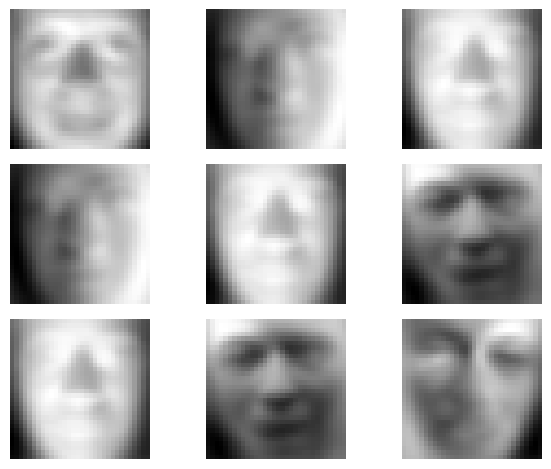

In [55]:
#Introduce aquí tu código para representar las 5 primeras autocaras
imgsize = 32
fig, ax = plot_grid_images(autovectores.reshape(autovectores.shape[0], imgsize, imgsize))
plt.show()

> 📝 **Pregunta 8.** Escribe aquí el código que permita visulizar los cinco últimos 5 autovectores en forma de imagen. Es decir, los 5 autovectores asociados a los 5 menores autovalores.

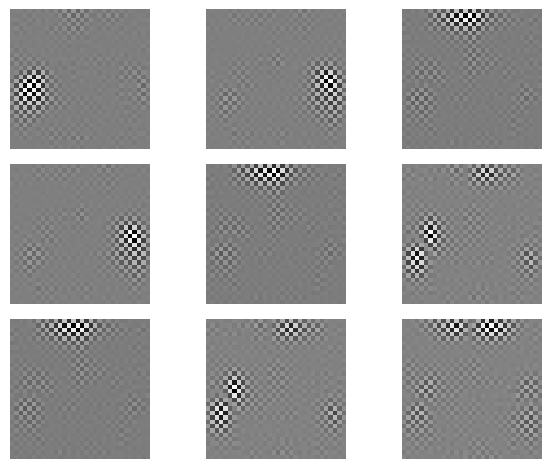

In [56]:
#Introduce aquí tu código para representar las 5 últimas
imgsize = 32
fix, ax = plot_grid_images(autovectores[::-1].reshape(autovectores.shape[0], imgsize, imgsize))
plt.show()

> 📝 **Pregunta 9.** ¿Por qué son tan diferentes? 

Los primeros autovectores tienen un mayor autovalor, significando que son capaces de captar mayor parte de la variabilidad de los datos. Es decir, contienen mucha más información que los posteriores. 
Es por ello, que visualizando los primeros observamos facetas similares a lo que esperaríamos cuando hablamos de retratos. No obstante, los últimos, con menor auto-valor, parecen activaciones aleatorias de la imagen.Podrian ser detalles de una imagen en concreto del dataset o ruido general.

# Cálculo de las componentes principales de los datos

Hasta ahora hemos obtenido los vectores (autovectores o autocaras) que definen el subespacio donde vamos a proyectar los datos. También hemos visto qué cantidad de varianza explica cada autovector. 

Vamos a fijar el número de autocaras a 250, es decir `n_componentes=250`.

> 📝 **Pregunta 10.** Extrae de `V` los `n_componentes` autovectores asociados a los `n_componentes` mayores autovalores y almacénalos en `W`. A continuación obtén la proyección (variables latentes) de nuestros datos y almacénalos en `Z`. Observa que lo que estamos haciendo es proyectar nuestros datos originales `X_norm` en el espacio generado por los vectores de `W`.

In [57]:
n_componentes = 250

# W contendrá los autovectores correspondientes a las n_componentes principales
# Transponemos porque lo habíamos transpuesto anteriormente
W = autovectores[:n_componentes, :].T

# Z contendrá las proyecciones de nuestros datos en el espacio latente
Z = (W.T @ X_norm.T).T
print(Z.shape)

(4500, 250)


# Visualización de las primeras componentes

Podemos visualizar la primera y la segunda componentes para ver que información nos aportan sobre nuestros datos. 

> 📝 **Pregunta 11.** Crea dos gráficas separadas. Una que muestre solo la primera componente (variable latente) y otra que incluya las dos primeras (variables latentes) de todo el conjunto de entrenamiento.

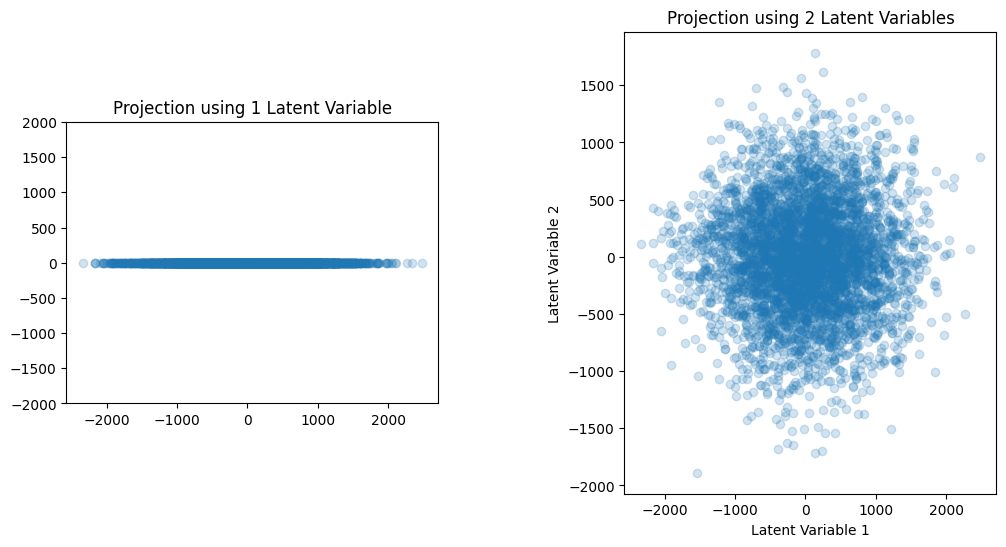

0.4369500257558132


In [58]:
# Incluye aquí el código de la creación de las gráficas
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(autovectores[0].reshape(32, 32), cmap='gray')
ax[0].scatter(Z[:, 0], [0] * len(Z), alpha=0.2)  # Usamos la primera componente
ax[0].set_title("Projection using 1 Latent Variable")
ax[0].set_ylim((-2000, 2000))
# ax[0].axis('off')
ax[1].scatter(Z[:, 0], Z[:, 1], alpha=.2)
ax[1].set_title("Projection using 2 Latent Variables")
ax[1].set_xlabel("Latent Variable 1")
ax[1].set_ylabel("Latent Variable 2")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)
plt.show()
print(cumvar[1])

> 📝 **Pregunta 12.** Comenta los resultados obtenidos.

Vemos que utilizando 1 sola variable latente obtenemos una línea sobre la cuál se proyectan los diferentes ejemplos de nuestro conjunto de datos. Vemos una gran cantidad de solapamiento de los ejemplos (véase la intensidad del azul en la zona central de ambas imágenes en comparación con los bordes), sobre todo al utilizar solamente 1 variable latente. Con 2 variables latentes, aunque ahora cubrimos alrededor del 44% de la variabilidad, también tenemos muchos solapamientos en la zona central. Cuánto mayor el número de variables latentes utilizamos, más información podemos captar y mejor distribuimos los ejemplos de nuestro conjunto de datos. 

# Recuperacion de los datos

A partir de las variables latentes almacenadas en `Z`, cada una de sus filas contiene la representación latente de cada uno de los ejemplos (filas) en `X_norm`, podemos reconstruir los datos. Observa que hemos pasado de 1024 rasgos a `n_componentes`. 

> 📝 **Pregunta 13.** Utiliza `Z` y los autovectores en `W` para reconstruir las caras originales. Ten en cuenta que tendrás que deshacer la normalización de los datos una vez hayas recuperado la dimensionalidad original.

In [59]:
#Introduce aquí tu código para recuperar los datos
print(W.shape, Z.shape)
X_norm_recovered = (W @ Z.T).T
print(X_norm_recovered.shape)
X_recovered = scaler.inverse_transform(X_norm_recovered)
print(X_recovered.shape)
X_recovered = X_recovered.reshape(X.shape[0], 32, 32)

(1024, 250) (4500, 250)
(4500, 1024)
(4500, 1024)


> 📝 **Pregunta 14.** Muestra las 5 primeras caras de la base de datos original y su reconstrucción. Si has hecho los pasos correctamente, la reconstrucción debe ser similar al original.

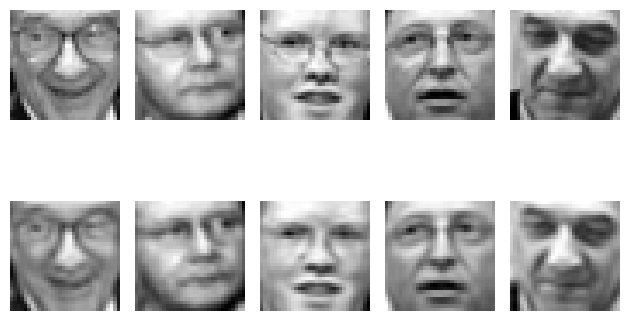

In [73]:
# Muestra 5 caras del dataset original y las mismas 5 caras reconstruidas
# fig, ax = plot_grid_images(X)
# fig.suptitle("Imágenes Originales")
# rfig, rax = plot_grid_images(X_recovered)
# rfig.suptitle(f"Imágenes Reconstruidjs con {n_componentes} componentes")
plot_ = np.concat([X[:5], X_recovered[:5]])
fig, ax = plot_grid_images(plot_, 2, 5)
plt.show()

> 📝 **Pregunta 15.** ¿Qué ocurre si aumentamos o disminuímos el número `n_componentes`?

Similar a la respuesta de la pregunta 9, y las visualizaciones obtenidas en las preguntas 7 y 8, al aumentar el número de componentes obtendríamos imágenes cada vez más parecidas con las originales llegando a obtener esencialmente la imágen original como vimos anteriormente en las comprobaciones de la pregunta 5. Y por otro lado, si disminuimos obtenemos ejemplos más difusos, como podemos ver a continuación.

(1024, 250) (4500, 250)


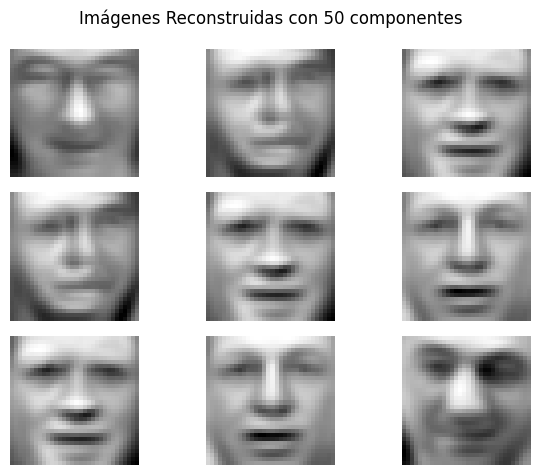

In [26]:
print(W.shape, Z.shape)
partial_norm = (W[:, :50] @ Z[:, :50].T).T
partial = scaler.inverse_transform(partial_norm)
partial = partial.reshape(X.shape[0], 32, 32)
fig, ax = plot_grid_images(partial)
fig.suptitle("Imágenes Reconstruidas con 50 componentes")
plt.show()

# Medición del error de reconstrucción

Según el número de componentes que hayamos utilizado, habremos perdido más o menos información. Podemos comprobarlo haciendo uso del error cuadratico medio (MSE). 

> 📝 **Pregunta 16.** Usando los datos originales de entrenamiento `X` y la reconstrucción que has obtenido, calcula el MSE que has cometido con cada una de las imágenes en `X`. 

In [27]:
#Introduce aquí tu código para calcular el MSE. Si lo has hecho bien, obtendrás un valor para cada elemento (fila) 
# de X.
mse = np.sum( (X - X_recovered)**2 )
print(mse)

134310110.3250988


In [28]:
partial_mse = np.sum( (X - partial)**2)
print(partial_mse)

988152707.499428


> 📝 **Pregunta 17.** Haciendo uso del error cuadrático medio identifica y muestra la imagen original y la reconstruida en los siguientes casos: la imagen peor reconstruida, la imagen mejor reconstruida.

(4500,)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

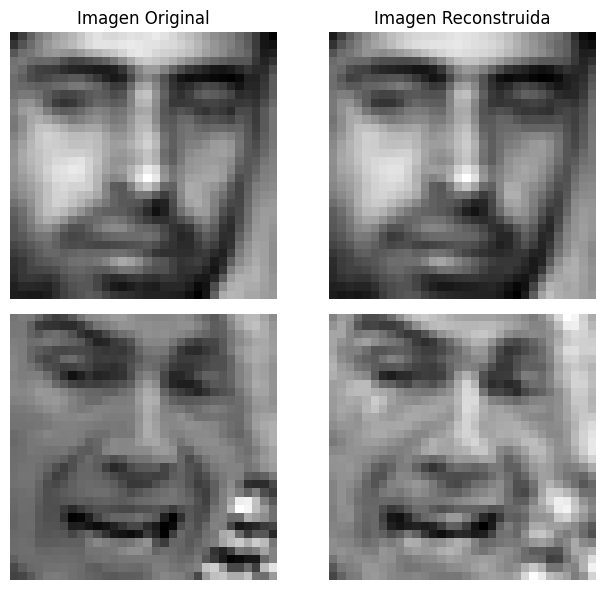

In [29]:
# Incluye el código para encontrar en el conjunto de entregamiento las imágenes peor y mejor reconstruidas usando el
# error cuadrático medio y muéstrales.
errores = np.sum((X.reshape(X.shape[0], -1) - X_recovered.reshape(X_recovered.shape[0], -1))**2, axis=1)
print(errores.shape)
indexes = np.argsort(errores)
mejor = indexes[0]
peor = indexes[-1]
fig, ax = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
ax[0][0].imshow(X[mejor, :], cmap='gray')
ax[0][0].axis('off')
ax[0][0].set_title('Imagen Original')
ax[0][1].imshow(X_recovered[mejor, :], cmap='gray')
ax[0][1].axis('off')
ax[0][1].set_title('Imagen Reconstruida')

ax[1][0].imshow(X[peor, :], cmap='gray')
ax[1][0].axis('off')
ax[1][1].imshow(X_recovered[peor, :], cmap='gray')
ax[1][1].axis('off')

> 📝 **Pregunta 18.** ¿Podrías explicar por qué son estas las caras que aparecen?

La reconstrucción será mejor para aquellos conjuntos de ejemplos que sean lo más parecido a la mayoría de los ejemplos de nuestros datos. Es decir, similar niveles de intensidad lumínica, formas y orientación (cerca a la tendencia central de nuestros datos). Podríamos justificar la peor reconstrucción de la imagen inferior por el extraño patrón de la esquina inferior derecha, donde vemos una variedad de tonalidades de grises cuando en la mayoría de las imágenes parece ser una zona gris plana. También vemos una tonalidad más oscura en general en la imagen. Además, siendo el erro cuadrático medio, las diferencias crecen rápidamente.

Si usamos solamente 50 componentes podemos observar que la peor imagen reconstruida tiene más marcado todas las sombras que la mejor reconstrucción, suponiendo una tendencia a zonas grises claras en nuestros datos.

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

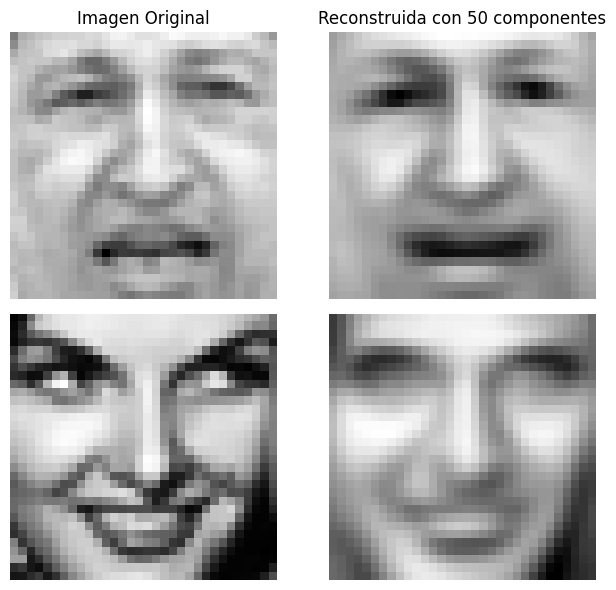

In [30]:
errores = np.sum((X.reshape(X.shape[0], -1) - partial.reshape(partial.shape[0], -1))**2, axis=1)
indexes = np.argsort(errores)
pmejor = indexes[0]
ppeor = indexes[-1]
fig, ax = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
ax[0][0].imshow(X[pmejor, :], cmap='gray')
ax[0][0].axis('off')
ax[0][0].set_title('Imagen Original')
ax[0][1].imshow(partial[pmejor, :], cmap='gray')
ax[0][1].axis('off')
ax[0][1].set_title('Reconstruida con 50 componentes')

ax[1][0].imshow(X[ppeor, :], cmap='gray')
ax[1][0].axis('off')
ax[1][1].imshow(partial[ppeor, :], cmap='gray')
ax[1][1].axis('off')

# Aplicando el modelo a datos nuevos 

Los autovectores o autocaras que hemos encontrado haciendo uso de `X` deberian ser suficientemente buenos para representar otros datos del mismo tipo. Vamos a comprobarlo haciendo uso del pequeño conjunto de test que separamos al principio de la práctica.

Utilizando los autovectores que ya has calculado, sigue los mismos pasos con las imagenes de test y comprueba que el funcionamiento es adecuado. 

> 📝 **Pregunta 19.** Normaliza las instancias de test.

In [31]:
# Normalización de los datos de test. (No olvides que no puedes utilizar información obtenida del propio 
# conjunto de test)

test_norm = scaler.transform(test.reshape(test.shape[0], -1))

> 📝 **Pregunta 20.** Obtén las variables latentes y reconstruye las caras del conjunto de test.

In [32]:
# Obtenición de las variables latentes y reconstrucción de las caras de test.
Z_test = (W.T @ test_norm.T).T
print(Z_test.shape)

Test_norm_recovered = (W @ Z_test.T).T
print(Test_norm_recovered.shape)

Test_recovered = scaler.inverse_transform(Test_norm_recovered)
print(Test_recovered.shape)


(500, 250)
(500, 1024)
(500, 1024)


> 📝 **Pregunta 21.** Muestra las cinco primeras caras del conjunto de test y sus reconstrucciones.

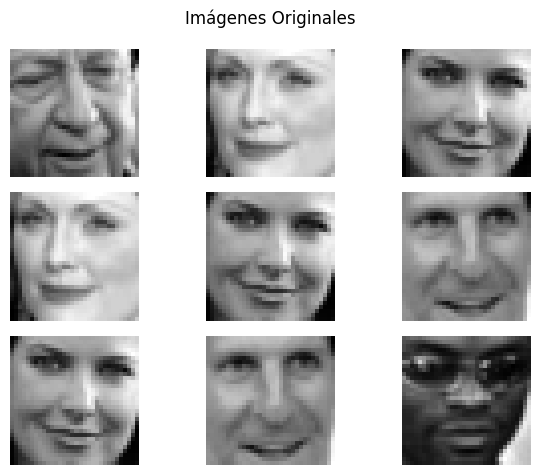

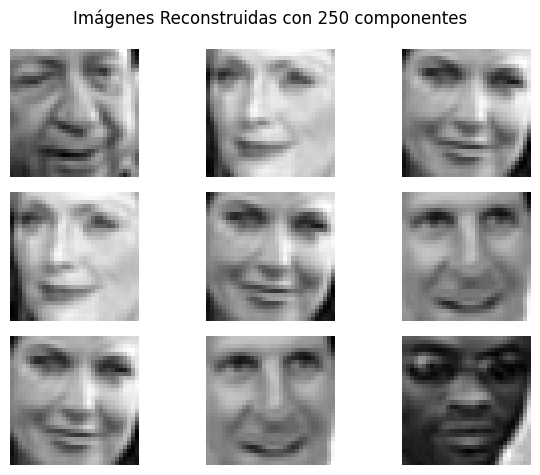

In [33]:
# Muestra 5 caras del conjunto de test y sus respectivas reconstrucciones
fig, ax = plot_grid_images(test)
fig.suptitle("Imágenes Originales")
plt.show()
fig, ax = plot_grid_images(Test_recovered.reshape(Test_recovered.shape[0], 32, 32))
fig.suptitle(f"Imágenes Reconstruidas con {n_componentes} componentes")
plt.show()

# Detección de anomalías

En el conjunto de test hay una imagen anómala que no se corresponde con el resto del dataset. ¿Como la identificarías automaticamente utilizando lo que has aprendido?

> 📝 **Pregunta 22.** Identifica y muestra la anomalía oculta en el conjunto de test. Muestra también la reconstrucción que hemos obtenido de esa anomalía.

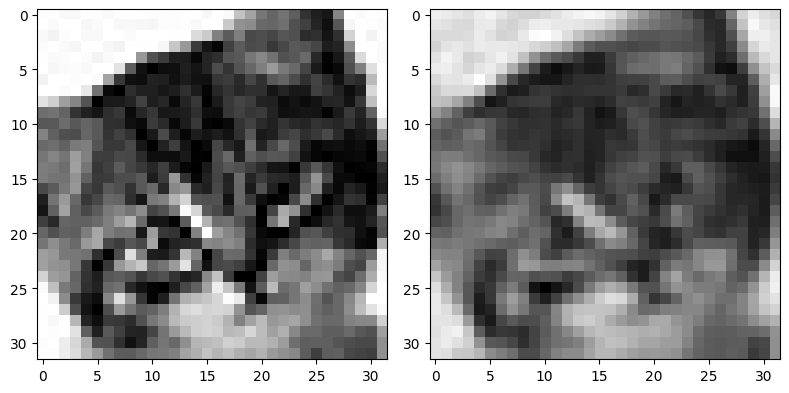

In [34]:
# Identifica la anomalía en el conjunto de test.
terrores = np.sum((test.reshape(test.shape[0], -1) - Test_recovered)**2, axis = 1)
tindexes = np.argsort(terrores)
peor = tindexes[-1]
fig, ax = plt.subplots(1, 2, figsize=(8, 6), tight_layout=True)
ax[0].imshow(test[peor, :].reshape(32, 32), cmap='gray')
ax[1].imshow(Test_recovered[peor, :].reshape(32, 32), cmap='gray')
plt.show()

> 📝 **Pregunta 23.** ¿Qué es lo que nos permite identificar la imagen como anomalía? ¿Por qué se reconstruye de esa manera?

Nuestro conjunto de datos de entrenamiento son imágenes de caras de seres humanos con diferentes ángulos, intensidades lumínicas, formas y géneros. Eso son las estructuras y características que nuestro modelo será capaz de modelar y reconstruir. Es por ello, que al insertar una imágen suficientemente lejana de lo esperado, como es el caso del gato, obtendremos una reconstrucción mala en comparación con las reconstrucciones de los datos más cercanos a nuestra distribución a priori. Aún así, la reeconstrucción tiene cierta cercania a la imágen original. Vemos la forma y las intensidades correctas. Aunque no se aprecia del todo la cara del animal.